# 1. Variational Autoencoder
In this notebook we shall present a simple conditional Variational Autoencoder, trained on MNIST. VAE is a type of generative model that combines principles from variational inference and autoencoders. It is used for generating new data samples that are similar to a given dataset. VAEs are particularly useful in scenarios such as image generation, data compression, and representation learning. 

## Components:

1. **Encoder**:
   - The encoder is a neural network that takes an input data sample (e.g., an image) and maps it to a latent space. Instead of directly outputting a single point in the latent space, the encoder outputs parameters of a probability distribution (typically a Gaussian distribution), namely the mean ($\mu$) and the standard deviation ($\sigma$).


2. **Latent Space**:
   - The latent space is a lower-dimensional representation of the input data. It captures the underlying factors of variation in the data. Each point in the latent space can be sampled to generate new data points.


3. **Decoder**:
   - The decoder is another neural network that takes a point from the latent space and maps it back to the data space. It reconstructs the original data sample from the latent representation.


## Working of VAE:

1. **Encoding**:
   - An input sample $x$ is passed through the encoder, which outputs the parameters $\mu$ and $\sigma$ of the latent distribution.
   - Instead of using a single deterministic point, a random sample $z$ is drawn from the Gaussian distribution defined by $\mu$ and $\sigma$. This sampling process is essential for the generative capabilities of the VAE.

2. **Reparameterization Trick**:
   - To enable backpropagation through the sampling process, the reparameterization trick is used. It involves expressing the sampled latent vector $z$ as:
     $
     z = \mu + \sigma \odot \epsilon
     $
     where $\epsilon$ is a random noise vector sampled from a standard normal distribution, and $\odot$ denotes element-wise multiplication.

3. **Decoding**:
   - The sampled latent vector $z$ is passed through the decoder to reconstruct the original data sample $\hat{x}$.

4. **Loss Function**:
   - The VAE is trained using a loss function that has two components:
     - **Reconstruction Loss**: Measures how well the reconstructed data $\hat{x}$ matches the original input $x$. This is typically the Mean Squared Error (MSE) for continuous data or Binary Cross-Entropy (BCE) for binary data.
     - **KL Divergence Loss**: Measures the divergence between the learned latent distribution $q(z|x)$ and the prior distribution $p(z)$, which is usually a standard normal distribution. This encourages the learned latent space to be close to the prior distribution.
     $$
     \mathcal{L} = \mathbb{E}_{q(z|x)}[\log p(x|z)] - D_{\text{KL}}(q(z|x) \parallel p(z))
     $$


## Notes
- **Generative Model**: VAEs are used to generate new data samples that resemble the training data.
- **Latent Space**: They learn a continuous, lower-dimensional latent space representing the data.
- **Probabilistic Encoder**: The encoder outputs a distribution over the latent space, rather than a single point.
- **Training Objective**: The training optimizes both the reconstruction of the input data and the regularization of the latent space distribution.

VAEs have found applications in various fields, including image generation, text generation, and anomaly detection, due to their ability to learn meaningful latent representations and generate diverse samples.

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras import utils
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

2024-05-20 18:53:19.152468: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-20 18:53:19.152642: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-20 18:53:19.310126: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


We want to use the variational autoencoder technique to generate digits similar to those in the MNIST dataset.

In [2]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))  # Result: (num_samples, 784)
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

y_train = utils.to_categorical(y_train)  # Converting integer labels to One-hot Encodding
y_test = utils.to_categorical(y_test)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# 2. Model
Sampling function is a key part of implementing a VAE. It is used to sample latent vectors from the learned latent space distribution during the encoding process. In a VAE, instead of encoding an input to a fixed point in the latent space, we encode it to a distribution (usually Gaussian). The sampling function performs the crucial step of sampling from this distribution to obtain a latent vector that will be passed to the decoder for reconstruction.

In [3]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), 
                              mean=0.,
                              stddev=1.)
    return z_mean + K.exp(z_log_var / 2) * epsilon

#### Code Explanation 
- The function takes a single argument args, which is a tuple containing `z_mean` and `z_log_var`. These are the outputs of the encoder network.
- `z_mean` represents the mean of the latent Gaussian distribution.
- `z_log_var` represents the logarithm of the variance of the latent Gaussian distribution.
- `epsilon` is a random noise vector sampled from a standard normal distribution with mean 0 and standard deviation 1.
    - `K.random_normal` is a Keras backend function to generate random normal values. The shape of `epsilon` matches the batch size and the dimensionality of the latent space (`latent_dim`).
- The return line implements the `reparameterization` trick, which allows the gradients to backpropagate through the sampling process.
    - `K.exp(z_log_var / 2)` computes the standard deviation from the log variance.
    - The latent vector `z` is computed by shifting the mean (`z_mean`) and scaling by the standard deviation (`K.exp(z_log_var / 2)`) with the random noise `epsilon`.

Main dimensions for the model (a simple stack of dense layers).

In [4]:
input_dim = 784
latent_dim = 16
intermediate_dim_1 = 128
intermediate_dim_2 = 32

## 2.1. Encoder
We start with the encoder. It takes two inputs: the image and the category. It returns the latent encoding `z_mean` and a `(log-)variance` for each latent variable.

In [5]:
# Input Layer
x = layers.Input(shape=(input_dim, ))  # Input shape equals to 28*28

# Dense Layers
h1 = layers.Dense(intermediate_dim_1, activation='swish')(x)
h2 = layers.Dense(intermediate_dim_2, activation='swish')(h1)

# Output Layers
z_mean = layers.Dense(latent_dim)(h2)
z_log_var = layers.Dense(latent_dim)(h2)

encoder = Model(x, [z_mean, z_log_var])

## 2.2. Decoder
Now we define the decoder. It takes in input a vector in the latent space, and it returns the image of a digit.

In [6]:
# Input Layer
y = layers.Input(shape=(latent_dim, ))

# Dense Layers
dec_mid_1 = layers.Dense(intermediate_dim_2, activation='swish')(y)
dec_mid_2 = layers.Dense(intermediate_dim_1, activation='swish')(dec_mid_1)

# Output Layer
x_hat = layers.Dense(input_dim, activation='sigmoid')(dec_mid_2)

decoder = Model(inputs=y, outputs=[x_hat])

## 2.3. Building VAE
We build the VAE by composing the encoder and the decoder. However, between them we need to insert the sampling operation. In order to wrap the sampling function into a layer we use a special layer called "lambda". 

Sample code is as follow, for our case, due to unexpected error, we have implemented our own Training class with respect to the following sample code:
```Python
# Input Layer
x = layers.Input(shape=(input_dim, ))

# Encoding
z_mean, z_log_var = encoder(x)

# Inserting Sampling Operation between Encoder-Decoder
z = layers.Lambda(sampling, output_shape=(latent_dim, ))([z_mean, z_log_var])

# Decoding
x_hat = decoder(z)

# Final Model is composed by the ...
vae = Model(x, x_hat)

```

In [7]:
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = sampling([z_mean, z_log_var])
            x_hat = self.decoder(z)
            loss = vae_loss(data, x_hat, z_mean, z_log_var)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        return {"loss": loss}

    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var = self.encoder(data)
        z = sampling([z_mean, z_log_var])
        x_hat = self.decoder(z)
        loss = vae_loss(data, x_hat, z_mean, z_log_var)
        return {"loss": loss}

# Instantiate and compile the VAE model
vae = VAE(encoder, decoder)

The VAE loss function is just the sum between the `reconstruction error` (mse or bce) and the `KL-divergence`, acting as a regularizer of the latent space. In other words, The loss function combines two components: the `reconstruction loss` and the `Kullback-Leibler (KL) divergence`. This combination ensures that the VAE learns to generate data that is similar to the input data while maintaining a well-formed latent space. 

- Reconstruction Loss:
    - Purpose: Measures how well the VAE can reconstruct the input data 𝑥 from the latent representation.
    
    
- KL-Divergence Loss:
    - Purpose: Regularizes the latent space to ensure that the learned distribution is close to a standard normal distribution 𝑁(0, 𝐼). This regularization prevents overfitting and ensures smooth interpolation in the latent space.

In [8]:
beta = 1.0 # balancing factor

# Custom loss function
def vae_loss(x, x_hat, z_mean, z_log_var):
    rec_loss = input_dim * metrics.binary_crossentropy(x, x_hat)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(rec_loss + kl_loss)

# Compile the model with the custom loss
vae.compile(optimizer='adam', loss=vae_loss)

# Summary of the model (optional)
vae.summary()


Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_1 (Functional)       │ ?                      │       105,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_3 (Functional)       │ ?                      │       105,904 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 211,568 (826.44 KB)

 Trainable params: 211,568 (826.44 KB)

 Non-trainable params: 0 (0.00 B)

#### Code Explanation
- `beta` Controls the trade-off between the reconstruction loss and the KL divergence loss.
    - By adjusting 𝛽, you can control the importance of the KL divergence regularization relative to the reconstruction loss. Setting 𝛽=1 gives equal weight to both losses. Adjusting 𝛽 can help in balancing between generating accurate reconstructions and ensuring a well-behaved latent space.
- `metrics.binary_crossentropy(x, x_hat)` computes the binary cross-entropy between the original input 𝑥 and the reconstructed output 𝑥^.
- `1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)` computes the element-wise KL divergence for each latent variable.
- `K.sum(..., axis=-1)` sums the KL divergence terms over the latent dimensions.

In [9]:
batch_size = 100
epochs = 50

Train for a sufficient amount of epochs. Generation is a more complex task than classification.

In [10]:
# Print shapes for debugging
print("Training data shape:", x_train.shape)
print("Validation data shape:", x_test.shape)

vae.fit(x_train, shuffle=True, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None))

vae.save_weights("vae.weights.h5")

Training data shape: (60000, 784)
Validation data shape: (10000, 784)
Epoch 1/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 192.7300 - val_loss: 0.0000e+00
Epoch 2/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 146.5652 - val_loss: 0.0000e+00
Epoch 3/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 136.1186 - val_loss: 0.0000e+00
Epoch 4/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 129.7634 - val_loss: 0.0000e+00
Epoch 5/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 125.2633 - val_loss: 0.0000e+00
Epoch 6/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 121.8837 - val_loss: 0.0000e+00
Epoch 7/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 118.9654 - val_loss: 0.0000e+00
Epoch 8/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 116.9854 - val_loss: 0.0000e+00
Epoch 9/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 115.6083 - val_loss: 0.0000e+00
Epoch 10/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 114.5964 - val_loss: 0.0000e+00
Epo

Let us plot some examples

In [11]:
def plot(images):
    n = images.shape[0]
    plt.figure(figsize=(2*n, 2))
    
    for i in range(n):
        # display original
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


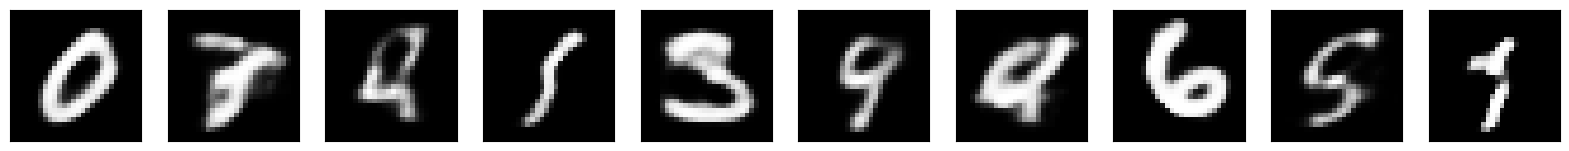

In [12]:
z_sample = np.random.normal(size=(10, latent_dim))  # Creating 10 samples - latent_dim is dimensionality of the latent space
generated = decoder.predict(z_sample)  # generates new data from the random latent samples.
plot(generated)